In [4]:
!pip install -q -r requirements.txt

In [7]:
!pip uninstall -y opencv-python-headless
!pip install opencv-python-headless==4.1.2.30

Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Successfully uninstalled opencv-python-headless-4.5.5.64
  Using cached opencv_python_headless-4.1.2.30-cp37-cp37m-manylinux1_x86_64.whl (21.8 MB)


## Data Loading

In [1]:
from os.path import join
import numpy as np 
import torch
import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_ROOT="./data/"

MRI_root_dir=join(DATA_ROOT,"MRI","MRI_Label")
MRI_anno_file=join(DATA_ROOT,"MRI","annotations/MRI_Label/annotations.json")
MRI_nonLabel_root_dir=join(DATA_ROOT,"MRI","MRI_nonLabel")
MRI_nonLabel_anno_file=join(DATA_ROOT,"MRI","annotations/MRI_nonLabel/annotations.json")

CT_root_dir=join(DATA_ROOT,"CT")
CT_anno_file=join(DATA_ROOT,"CT","annotations/annotations.json")

In [ ]:
import albumentations as A
WIDTH, HEIGHT=256,256

class DivMax(A.ImageOnlyTransform):
    def __init__(self, always_apply=True, p=1.0):
        super().__init__(always_apply, p)
    def apply(self, img, **params):
        img=img/np.max(img)
#         img[img<0.25]=0
#         img[img>0.65]=0
        return img
    
transform = A.Compose([
  A.ToFloat(always_apply=True),
  DivMax(always_apply=True),
  A.Resize(WIDTH, HEIGHT),
  A.HorizontalFlip(p=0.5),
  A.RandomBrightnessContrast(brightness_limit=[-0.05, 0.05], p=0.2),
  A.Rotate((-30, 30), interpolation=0), 
  A.RandomContrast(limit=0.2, p=1),   
])

test_transform = A.Compose([           
  A.ToFloat(always_apply=True),
  DivMax(always_apply=True),
  A.Resize(WIDTH, HEIGHT),
])

In [ ]:
from dataloaders.ctmri_multiclass import CTMRI_MultiClassDataset,CTMRI_InferenceDataset,CTMRI_SSLDataset

ds_kwargs=dict(
    transform=transform,
    test_transform=test_transform,
    test_split=0.2
    )
MRI_ds=CTMRI_MultiClassDataset(MRI_anno_file,MRI_root_dir,**ds_kwargs)
MRI_nonLabel_ds=CTMRI_SSLDataset(MRI_nonLabel_anno_file,MRI_nonLabel_root_dir,transform=transform,test_transform=test_transform)

CT_ds=CTMRI_MultiClassDataset(CT_anno_file,CT_root_dir,**ds_kwargs)

In [5]:
import torch.utils.data as tud
ldr_kwargs=dict(
    batch_size=8,
    shuffle=True,
    pin_memory=False,
    num_workers=2,
    drop_last=True
)
CT_loader=tud.DataLoader(CT_ds,**ldr_kwargs)
MRI_loader=tud.DataLoader(MRI_ds,**ldr_kwargs)
MRI_nonLabel_loader=tud.DataLoader(MRI_nonLabel_ds,**ldr_kwargs)

In [6]:
from dataloaders.ctmri_multiclass import occr_in_ds

MRI_occr=occr_in_ds(MRI_ds)
CT_occr=occr_in_ds(CT_ds)

BATCHSIZE= 3
(3, 256, 256, 3) 
 (3, 256, 256)


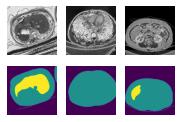

In [7]:
from utils.plotting import show_image_annot
CT_ds.training=True
x,y=next(iter(CT_loader))
show_image_annot(x.numpy().transpose(0,2,3,1),y.numpy(),showPics=3, vmax=CT_ds.n_cats)

In [8]:
set(y.flatten().numpy())

{0, 1, 2}

In [9]:
from models.unet import UNet
from models.head import MetricLayer
from models.models import SegModel
unet_pretrain = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True).cuda()
backbone=UNet(unet_pretrain).cuda()
latent_dims=32
head=MetricLayer(n_in_features=latent_dims,n_out_features=1+CT_ds.n_cats).cuda()
model_ct=SegModel(backbone,head,(WIDTH, HEIGHT)).cuda()

Using cache found in /home/jovyan/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [10]:
# from torchsummary import summary
# summary(backbone.encoder, (3, 224, 224))

In [11]:
def calc_acc(pred, y):
    correct=(pred.argmax(1)==y).flatten()
    return torch.sum(correct)/len(correct)
def one_batch(i_iter,log,sample_batched,model,criterion,optimizer):
    # Prep input
    x,y=[_.cuda() for _ in sample_batched]
    pred=model(x)
    loss = criterion(pred, y)
    if model.training:
        #Update
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    with torch.no_grad():
        acc=calc_acc(pred, y).item()
        if i_iter==0:
            log['acc'] = acc
        else:
            log['acc'] = (acc+log['acc']*i_iter)/(i_iter + 1)
    # Record
    loss_rec = loss.item()
    log['loss'] = (loss_rec+log['loss']*i_iter)/(i_iter + 1)
    return pred,loss


In [12]:
!mkdir snapshots

mkdir: cannot create directory ‘snapshots’: File exists


In [16]:
from losses.marginal import AddMarginLoss
# w=1/torch.tensor(CT_occr,dtype=torch.float32).cuda()
w=torch.tensor([0.2,0.2,0.6],dtype=torch.float32).cuda()
criterion_ct = AddMarginLoss(ways=1+CT_ds.n_cats,
                             s=10 ,m=1.4,gamma=3,
                             weight=w)
# optimizer_ct = torch.optim.SGD(model_ct.parameters(),lr=1e-3,momentum=0.9,weight_decay=0.0005)
optimizer_ct = torch.optim.Adam(model_ct.parameters(),lr=1e-3)
# 
# scheduler = MultiStepLR(optimizer, milestones=[100, 200, 300], gamma=0.1)
# 

In [17]:
from tqdm import tqdm

In [18]:
EPOCH=100
model_ct.train()
best_loss=np.inf
PAITIENCE=5
count=0
try:
    for e in range(EPOCH):
        log= {'epoch':e,'step':0,'loss': 0, 'acc': 0}
        model_ct.train()
        CT_ds.training=True
        session=tqdm(enumerate(CT_loader))
        for i_iter, sample_batched in session:
            pred,loss=one_batch(i_iter,log,sample_batched,model_ct,criterion_ct,optimizer_ct)
            # print loss and take snapshots
            if (i_iter + 1) % 5 == 0:
                log['step']=i_iter+1
                session.set_postfix(log)
        # validate
        if (e + 1) % 2 == 0:
            log = {'epoch':e,'step':'val','loss': 0, 'acc': 0}
            model_ct.eval()
            CT_ds.training=False
            session=tqdm(enumerate(CT_loader))
            with torch.no_grad():
                for i_iter,sample_batched in session:
                    pred,loss=one_batch(i_iter,log,sample_batched,model_ct,criterion_ct,optimizer_ct)
                    if (i_iter + 1) % 5 == 0:
                        session.set_postfix(log)
            # early stop        
            if log["loss"]<best_loss:
                best_loss=log["loss"]
                torch.save(model_ct.state_dict(), 'snapshots/unet_arc_ct_best.pth')
            elif count<=PAITIENCE: count+=1
            else:
                count=0
                best_loss=np.inf
                break 
            
except KeyboardInterrupt:
    print("\nHuman Interrupted")
torch.save(model_ct.state_dict(), 'snapshots/unet_arc_ct_latest.pth')

287it [00:47,  6.10it/s, epoch=0, step=285, loss=5.66, acc=0.933]
287it [00:38,  7.47it/s, epoch=1, step=285, loss=2.71, acc=0.97] 
71it [00:03, 18.63it/s, epoch=1, step=val, loss=2.18, acc=0.983]
287it [00:38,  7.43it/s, epoch=2, step=285, loss=2.34, acc=0.977]
287it [00:38,  7.42it/s, epoch=3, step=285, loss=2.1, acc=0.983] 
71it [00:03, 18.47it/s, epoch=3, step=val, loss=2.08, acc=0.984]
287it [00:38,  7.40it/s, epoch=4, step=285, loss=2.07, acc=0.984]
287it [00:38,  7.40it/s, epoch=5, step=285, loss=2.01, acc=0.985]
71it [00:03, 18.38it/s, epoch=5, step=val, loss=2.03, acc=0.985]
287it [00:38,  7.40it/s, epoch=6, step=285, loss=1.99, acc=0.986]
287it [00:38,  7.39it/s, epoch=7, step=285, loss=2.06, acc=0.984]
71it [00:03, 18.68it/s, epoch=7, step=val, loss=2.28, acc=0.972]
287it [00:38,  7.37it/s, epoch=8, step=285, loss=1.98, acc=0.986]
287it [00:38,  7.37it/s, epoch=9, step=285, loss=1.97, acc=0.986]
71it [00:03, 17.84it/s, epoch=9, step=val, loss=1.88, acc=0.988]
287it [00:38,  

In [15]:
model_ct.load_state_dict(torch.load("snapshots/unet_arc_ct_best.pth"))

<All keys matched successfully>

In [19]:
model_ct.eval()
CT_ds.training=False
session=tqdm(enumerate(CT_loader))
with torch.no_grad():
    log = {'epoch':1,'step':'test','loss': 0, 'acc': 0}
    for i_iter,sample_batched in session:
        pred,loss=one_batch(i_iter,log,sample_batched,model_ct,criterion_ct,optimizer_ct)
        session.set_postfix(log)
        break

0it [00:00, ?it/s, epoch=1, step=test, loss=1.69, acc=0.994]


BATCHSIZE= 3
(3, 256, 256) 
 (3, 256, 256)


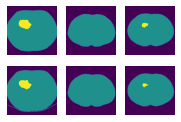

In [20]:
show_image_annot(pred.cpu().detach().argmax(1).numpy(),
                 sample_batched[1].cpu().detach().numpy(),
                 showPics=3, vmax=CT_ds.n_cats)

In [23]:
backbone.train()
backbone.requires_grad_(True)
head.eval()
head.requires_grad_(False)
WAYS=1+CT_ds.n_cats

unet_pretrain2 = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=False).cuda()
backbone_s=UNet(unet_pretrain2).cuda()
head_s=MetricLayer(n_in_features=latent_dims,n_out_features=WAYS).cuda()

teacher=SegModel(backbone,head,(WIDTH, HEIGHT)).cuda()
student=SegModel(backbone_s,head_s,(WIDTH, HEIGHT)).cuda()

w=1-torch.tensor(MRI_occr[:WAYS],dtype=torch.float32).cuda()/
# w=torch.tensor([0.1,0.1,0.2,0.2,0.2,0.2],dtype=torch.float32).cuda()
criterion_mri = AddMarginLoss(ways=WAYS,s=10 ,m=1.4,gamma=3,weight=w)
optimizer_t = torch.optim.SGD(teacher.parameters(),lr=1e-3,momentum=0.9,weight_decay=0.0005)
optimizer_s = torch.optim.SGD(student.parameters(),lr=1e-3,momentum=0.9,weight_decay=0.0005)

Using cache found in /home/jovyan/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [24]:
from torch.nn import functional as F
def one_batch_pseudo_label(i_iter,log,
                           labeled_batch,nonlabeled_batch,
                           teacher,student,
                           criterion,
                           optimizer_t,optimizer_s):
    # Prep input
    
    x_l,y=[_.cuda() for _ in labeled_batch]
    x_uw,x_us=[_.cuda() for _ in nonlabeled_batch]
    batch_size=len(y)
        
    # Train student
    ## Get teacher latents
    t_logits=teacher(torch.cat((x_l,x_uw,x_us)))
    t_logits_l,t_logits_uw, t_logits_us = t_logits.chunk(3)
    del t_logits
    ## For t_logits_l 
    t_loss_l=criterion(t_logits_l, y)
    ## For t_logits_uw 
    t_y_pseudo_soft = torch.softmax(t_logits_uw.detach()/10.0, dim=1)
    max_probs, t_y_pseudo_hard_uw = torch.max(t_y_pseudo_soft, dim=1)
    t_mask = max_probs.ge(0.4).float()
    ## For t_logits_us
    t_loss_u = torch.mean(
                -(t_y_pseudo_soft * torch.log_softmax(t_logits_us, dim=1)).sum(dim=1) * t_mask
            )
    weight_u = min(1., (log["epoch"] + 1) / 100)
    ## Teacher losss from labed data and soft teacher-pseudo label
    t_loss_uda = t_loss_l + weight_u * t_loss_u
    ## Get student latents
    s_logits=student(torch.cat((x_l,x_us)))
    s_logits_l, s_logits_us = s_logits.chunk(2)
    del s_logits
    ## Student loss from hard teacher-pseudo label
    s_loss_l_old = criterion(s_logits_l.detach(), y)
    s_loss_u = criterion(s_logits_us, t_y_pseudo_hard_uw)
    ## Update student (only with teacher-pseudo label)
    s_loss_u.backward()
    torch.nn.utils.clip_grad_norm_(student.parameters(), 1e-9)
    optimizer_s.step()
    
    
    # Train Teacher
    ## Get new student logits
    with torch.no_grad():
        s_logits_l_new = student(x_l)
    s_loss_l_new = criterion(s_logits_l_new.detach(), y)
    
    ## Distance of old, new student loss (for deriving similarity of old, new student gradiet)
    loss_distance = s_loss_l_new - s_loss_l_old
    ## Get hard teacher-pseudo label for another augmentation
    _, t_y_pseudo_hard_us = torch.max(t_logits_us.detach(), dim=1)
    ## Weighted loss derived by the hard teacher-pseudo pseudo label
    t_loss_mpl = loss_distance * criterion(t_logits_us, t_y_pseudo_hard_us)
    t_loss = t_loss_uda + t_loss_mpl
    ## Update student (only with teacher-pseudo label)
    t_loss.backward()
    torch.nn.utils.clip_grad_norm_(teacher.parameters(), 1e-9)
    optimizer_t.step()
    optimizer_t.zero_grad()
    optimizer_s.zero_grad()
    
    
    with torch.no_grad():
        acc=calc_acc(pred, y).item()
        if i_iter==0:
            log['acc'] = acc
        else:
            log['acc'] = (acc+log['acc']*i_iter)/(i_iter + 1)
    # Record
    loss_rec = loss.item()
    log['loss'] = (loss_rec+log['loss']*i_iter)/(i_iter + 1)
    return pred,loss

In [25]:
from tqdm import tqdm
from torch.cuda import amp

EPOCH=1000
teacher.train()
best_loss=np.inf
PAITIENCE=100
count=0
try:
    with amp.autocast():
        for e in range(EPOCH):
            log= {'epoch':e,'step':0,'loss': 0, 'acc': 0}
            teacher.train()
            MRI_ds.training=True
            session=tqdm(enumerate(zip(MRI_loader,MRI_nonLabel_loader)))
            for i_iter, sample_batched in session:

                labeled_batch,nonlabeled_batch=sample_batched
                pred,loss=one_batch_pseudo_label(i_iter,
                                                 log,
                                                 labeled_batch,nonlabeled_batch,
                                                 teacher,student,
                                                 criterion_mri,
                                                 optimizer_t,optimizer_s)
                # print loss and take snapshots
                if (i_iter + 1) % 5 == 0:
                    log['step']=i_iter+1
                    session.set_postfix(log)
            # validate
            if (e + 1) % 2 == 0:
                log = {'epoch':e,'step':'val','loss': 0, 'acc': 0}
                teacher.eval()
                MRI_ds.training=False
                session=tqdm(enumerate(MRI_loader))
                with torch.no_grad():
                    for i_iter,sample_batched in session:
                        pred,loss=one_batch(i_iter,log,sample_batched,teacher,criterion_mri,optimizer_t)
                        session.set_postfix(log)

                # early stop        
                if log["loss"]<best_loss:
                    best_loss=log["loss"]
                    torch.save(teacher.state_dict(), 'snapshots/unet_arc_mri_best.pth')
                elif count<=PAITIENCE: count+=1
                else:
                    count=0
                    best_loss=np.inf
                    break 
            
except KeyboardInterrupt:
    print("\nHuman Interrupted")
torch.save(teacher.state_dict(), 'snapshots/unet_arc_mri_latest.pth')

15it [00:09,  1.60it/s, epoch=0, step=15, loss=1.69, acc=0.765]
15it [00:12,  1.16it/s, epoch=1, step=15, loss=1.69, acc=0.759]
3it [00:00, 10.11it/s, epoch=1, step=val, loss=8.4, acc=0.852] 
15it [00:09,  1.60it/s, epoch=2, step=15, loss=8.28, acc=0.825]
15it [00:09,  1.59it/s, epoch=3, step=15, loss=8.28, acc=0.827]
3it [00:00,  7.38it/s, epoch=3, step=val, loss=8.58, acc=0.84] 
15it [00:09,  1.57it/s, epoch=4, step=15, loss=9.48, acc=0.813]
15it [00:09,  1.58it/s, epoch=5, step=15, loss=9.48, acc=0.812]
3it [00:00, 10.22it/s, epoch=5, step=val, loss=8.74, acc=0.833]
15it [00:09,  1.58it/s, epoch=6, step=15, loss=9.63, acc=0.845]
15it [00:09,  1.57it/s, epoch=7, step=15, loss=9.63, acc=0.843]
3it [00:00,  9.56it/s, epoch=7, step=val, loss=8.71, acc=0.831]
15it [00:09,  1.58it/s, epoch=8, step=15, loss=8.35, acc=0.787]
15it [00:09,  1.57it/s, epoch=9, step=15, loss=8.35, acc=0.793]
3it [00:00, 10.10it/s, epoch=9, step=val, loss=9.1, acc=0.825] 
15it [00:09,  1.57it/s, epoch=10, step=1

In [20]:
teacher.load_state_dict(torch.load("snapshots/unet_arc_mri_best.pth"))

<All keys matched successfully>

In [42]:
teacher.eval()
MRI_ds.training=False
session=tqdm(enumerate(MRI_loader))
with torch.no_grad():
    log = {'epoch':1,'step':'val','loss': 0, 'acc': 0}
    for i_iter,sample_batched in session:
        pred,loss=one_batch(i_iter,log,sample_batched,teacher,criterion_mri,optimizer_t)
        session.set_postfix(log)
        break

0it [00:00, ?it/s, epoch=1, step=val, loss=2.7, acc=0.988]


BATCHSIZE= 8
(8, 256, 256) 
 (8, 256, 256)


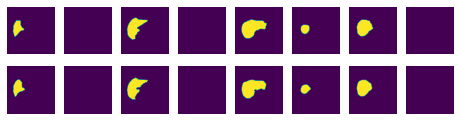

In [43]:
show_image_annot((pred.cpu().detach()[:,2]>=0.5).numpy(),
# show_image_annot((pred.cpu().detach().argmax(1)).numpy(),
                 (sample_batched[1]==2).cpu().detach().numpy(),
                 showPics=8, vmax=1)

In [44]:
set(sample_batched[1].flatten().numpy())

{0, 1, 2}

In [45]:
ds_kwargs=dict(
    transform=transform,
    test_transform=None,
    test_split=None
    )
MRI_ds=CTMRI_MultiClassDataset(MRI_anno_file,MRI_root_dir,**ds_kwargs)
MRI_loader=tud.DataLoader(MRI_ds,**ldr_kwargs)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [26]:
teacher.train()
MRI_ds.training=True
for e in range(3):
    log= {'epoch':e,'step':0,'loss': 0, 'acc': 0}
    session=tqdm(enumerate(MRI_loader))
    for i_iter, sample_batched in session:
        pred,loss=one_batch(i_iter,log,sample_batched,teacher,criterion_mri,optimizer_t)
        # print loss and take snapshots
        if (i_iter + 1) % 5 == 0:
            log['step']=i_iter+1
            session.set_postfix(log)

19it [00:02,  7.23it/s, epoch=0, step=15, loss=2.86, acc=0.982]
19it [00:02,  7.38it/s, epoch=1, step=15, loss=2.81, acc=0.984]
19it [00:02,  7.40it/s, epoch=2, step=15, loss=2.82, acc=0.983]


In [46]:
from dataloaders.ctmri_multiclass import CTMRI_InferenceDataset
ds_kwargs=dict(
    transform=test_transform,
    test_split=None
    )
ldr_kwargs=dict(
    batch_size=8,
    shuffle=False,
    pin_memory=False,
    num_workers=2
)
test_root_dir=join(DATA_ROOT,"testset")
test_anno_file=join(DATA_ROOT,"testset","annotations/annotations_gt.json")
test_ds=CTMRI_MultiClassDataset(test_anno_file,test_root_dir,**ds_kwargs)
# test_ds=CTMRI_InferenceDataset(test_anno_file,test_root_dir,test_transform=test_transform)
test_loader=tud.DataLoader(test_ds,**ldr_kwargs)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [47]:
teacher.eval()
test_ds.training=True
session=tqdm(enumerate(test_loader))
with torch.no_grad():
    for i_iter,sample_batched in session:
        pred,loss=one_batch(i_iter,log,sample_batched,teacher,criterion_mri,optimizer_t)
        session.set_postfix(log)
        break

0it [00:01, ?it/s, epoch=1, step=val, loss=8.65, acc=0.741]


In [48]:
test_ds=CTMRI_InferenceDataset(test_anno_file,test_root_dir,test_transform=test_transform)
test_loader=tud.DataLoader(test_ds,**ldr_kwargs)
teacher.eval()
pred=[]
with torch.no_grad():
    for xx in test_loader:
        pred.append(teacher(xx.cuda()))
pred=torch.cat(pred)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [49]:
predictions=pred.cpu().detach().numpy()

In [50]:
np.savez("prediction.npz",predictions)

In [51]:
def mask2rle(img):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
output=[*map(mask2rle,(predictions.argmax(1)==2).astype("int8"))]
# output=[*map(mask2rle,(predictions[:,2]>0.5).astype("int8"))]

In [52]:
import pandas as pd
df=pd.read_csv("sample_submission.csv")
df["rle"]=output
df.to_csv("submission_pretrain_plabel_argmax.csv",index=False)